# Descriptive Vancouver Weather Classification from Measurements

### Introduction
In our present-day, weather forecasting is essential for providing vital information about severe weather threats and risk management (Weyn et al., 2019). However, this is difficult to model because weather is a chaotic system, and highly sensitive to initial conditions (Lorenz, 1963). Therefore, weather cannot be modeled simply by qualitative phenomenon description, due to chaos in the quantitative measurements of weather instruments. 

This project seeks to address the problem that quantitative measurements do not describe a qualitative pattern in isolation. Are chaotic systems such as weather, difficult to predictively model, able to be predictively classified? This project will use the k-nearest-neighbour model to classify weather based on quantitative predictive variables, and study the accuracy of this model to answer this.


The dataset we will use is [Historical Hourly Weather Data](https://www.kaggle.com/selfishgene/historical-hourly-weather-data). It includes data over separate csv files for different variables, like humidity.csv, pressure.csv etc. We are going to combine them into one dataset and focus on only the city of Vancouver due to the sheer volume of data, with date-time, description of weather, humidity, pressure, wind speed and temperature.

### Methods and Results

#### Loading, Tidying and Splitting Data:

We only use data for Vancouver (for consistency of prediction and volume of data) for variables. We decide to use less esoteric weather terms and making description a factor, because the descriptions in orginal data are too specific. For example : broken clouds, overcast clouds, scattered clouds. We generalize them to type  "cloudy". After data wrangling, we split the data into training and testing sets and set seed 1234 to make it reproducible, and then perform k-nearest neighbour classification.

##### Loading Libraries and Data

In [2]:
install.packages("themis")

also installing the dependencies ‘fastmatch’, ‘ParamHelpers’, ‘BBmisc’, ‘checkmate’, ‘parallelMap’, ‘XML’, ‘hardhat’, ‘ipred’, ‘mlr’, ‘doParallel’, ‘FNN’, ‘recipes’, ‘generics’, ‘RANN’, ‘ROSE’, ‘unbalanced’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [ ]:
library(themis)
library(tidyverse)
library(tidymodels)
library(cowplot)

First, we load in the variables relevant for our analysis, and then select the vancouver column. We excluded wind direction, since it is more relevant for predicting the exact weather forecast, but not exactly relevant to predicting weather type descriptions, so it is excluded from our model. 

In [33]:
humidity_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/humidity.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
pressure_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/pressure.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
temperature_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/temperature.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
wind_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/wind_speed.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
description_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/weather_description.csv", col_types = cols()) %>%
            select(datetime, Vancouver)

Next, we merge the seperate dataframes using left_join, and use the time to pair the observations together, omit the null values, and convert the temperature from degrees Kelvin to Celsius.

In [2]:
weather_data_verbose = left_join(humidity_van, pressure_van, by = "datetime") %>%
                left_join(temperature_van, by = "datetime") %>%
                left_join(wind_van, by = "datetime") %>%
                left_join(description_van, by = "datetime") %>%
                `colnames<-`(c("datetime", "humidity.pct", "pressure.kpa", "temperature.c", "wind_speed.ms", "description")) %>%
                na.omit() %>%
                mutate(temperature.c = temperature.c - 273.15)

##### Using Less Esoteric Weather Terms and Making Description a Factor

In [32]:
# use case_when on the different descriptions to collapse ~40 weather descriptions to 7.

weather_data = weather_data_verbose %>% 
            filter(description != 'volcanic ash' & description != 'dust' & description != 'smoke' & description != 'haze') %>%
            mutate(description = case_when(description %in% c('broken clouds', 'few clouds', 'overcast clouds', 'scattered clouds', 'ragged thunderstorm', 'proximity thunderstorm') ~ 'cloudy',
                                           description %in% c('heavy intensity rain', 'heavy intensity shower rain', 'very heavy rain', 'thunderstorm with heavy rain') ~ 'heavy rain',
                                           description %in% c('drizzle', 'light intensity drizzle', 'light intensity drizzle rain', 'light intensity shower rain', 'light rain and snow', 'thunderstorm with light rain') ~ 'light rain',
                                           description %in% c('heavy shower snow', 'light shower snow', 'heavy snow', 'light snow', 'shower snow', 'sleet', 'light shower sleet') ~ 'snow',
                                           description %in% c('proximity shower rain', 'shower rain', 'thunderstorm with rain', 'thunderstorm') ~ 'moderate rain',
                                           description == 'mist' ~ 'fog',
                                           description == 'sky is clear' ~ 'clear sky',
                                           TRUE ~ description)) %>%
            mutate(description = as.factor(description))

##### Splitting Data into Testing and Training Set

In [38]:
set.seed(1234)

weather_split <- initial_split(weather_data, prop = 0.80, strata = description)  
weather_train <- training(weather_split)   
weather_test <- testing(weather_split)

#weather_train is ~32000 rows, weather_test is ~8000 rows

#### Visualizations

##### Distribution of each Weather Type in Training Data

In [40]:
sums = group_by(weather_train, description) %>%
    summarize(occurences = n(), .groups = 'drop') %>%
    #mutate(description = toTitleCase(description)) %>%
    setNames(c("Description:", "Occurences:")) %>%
    t() %>%
    cbind(c("total", nrow(weather_train)))

sums

Description:,clear sky,cloudy,fog,heavy rain,light rain,moderate rain,snow,total
Occurences:,9642,10686,3661,537,5235,1784,487,32032


*Figure 1.0*

Since the value in Figure 1.0 show large deviation between classes, our model will include upsampling to minimize this difference.

##### 6 Number Sumaries of Each Predictive Variable

In [41]:
summary(select(weather_train, -datetime, -description))

  humidity.pct  pressure.kpa  temperature.c    wind_speed.ms  
 Min.   : 12   Min.   : 810   Min.   :-28.00   Min.   : 0.00  
 1st Qu.: 73   1st Qu.:1012   1st Qu.:  6.48   1st Qu.: 1.00  
 Median : 86   Median :1017   Median : 10.81   Median : 2.00  
 Mean   : 82   Mean   :1018   Mean   : 11.02   Mean   : 2.54  
 3rd Qu.: 93   3rd Qu.:1022   3rd Qu.: 15.71   3rd Qu.: 4.00  
 Max.   :100   Max.   :1100   Max.   : 33.85   Max.   :25.00  

*Figure 1.1*

As the values in Figure 1.1 have very different scales, and ranges, we will also being scaling and centering the model for predictive accuracy.

##### Histogram Distributions of Each Predictive Variable by Weather Type

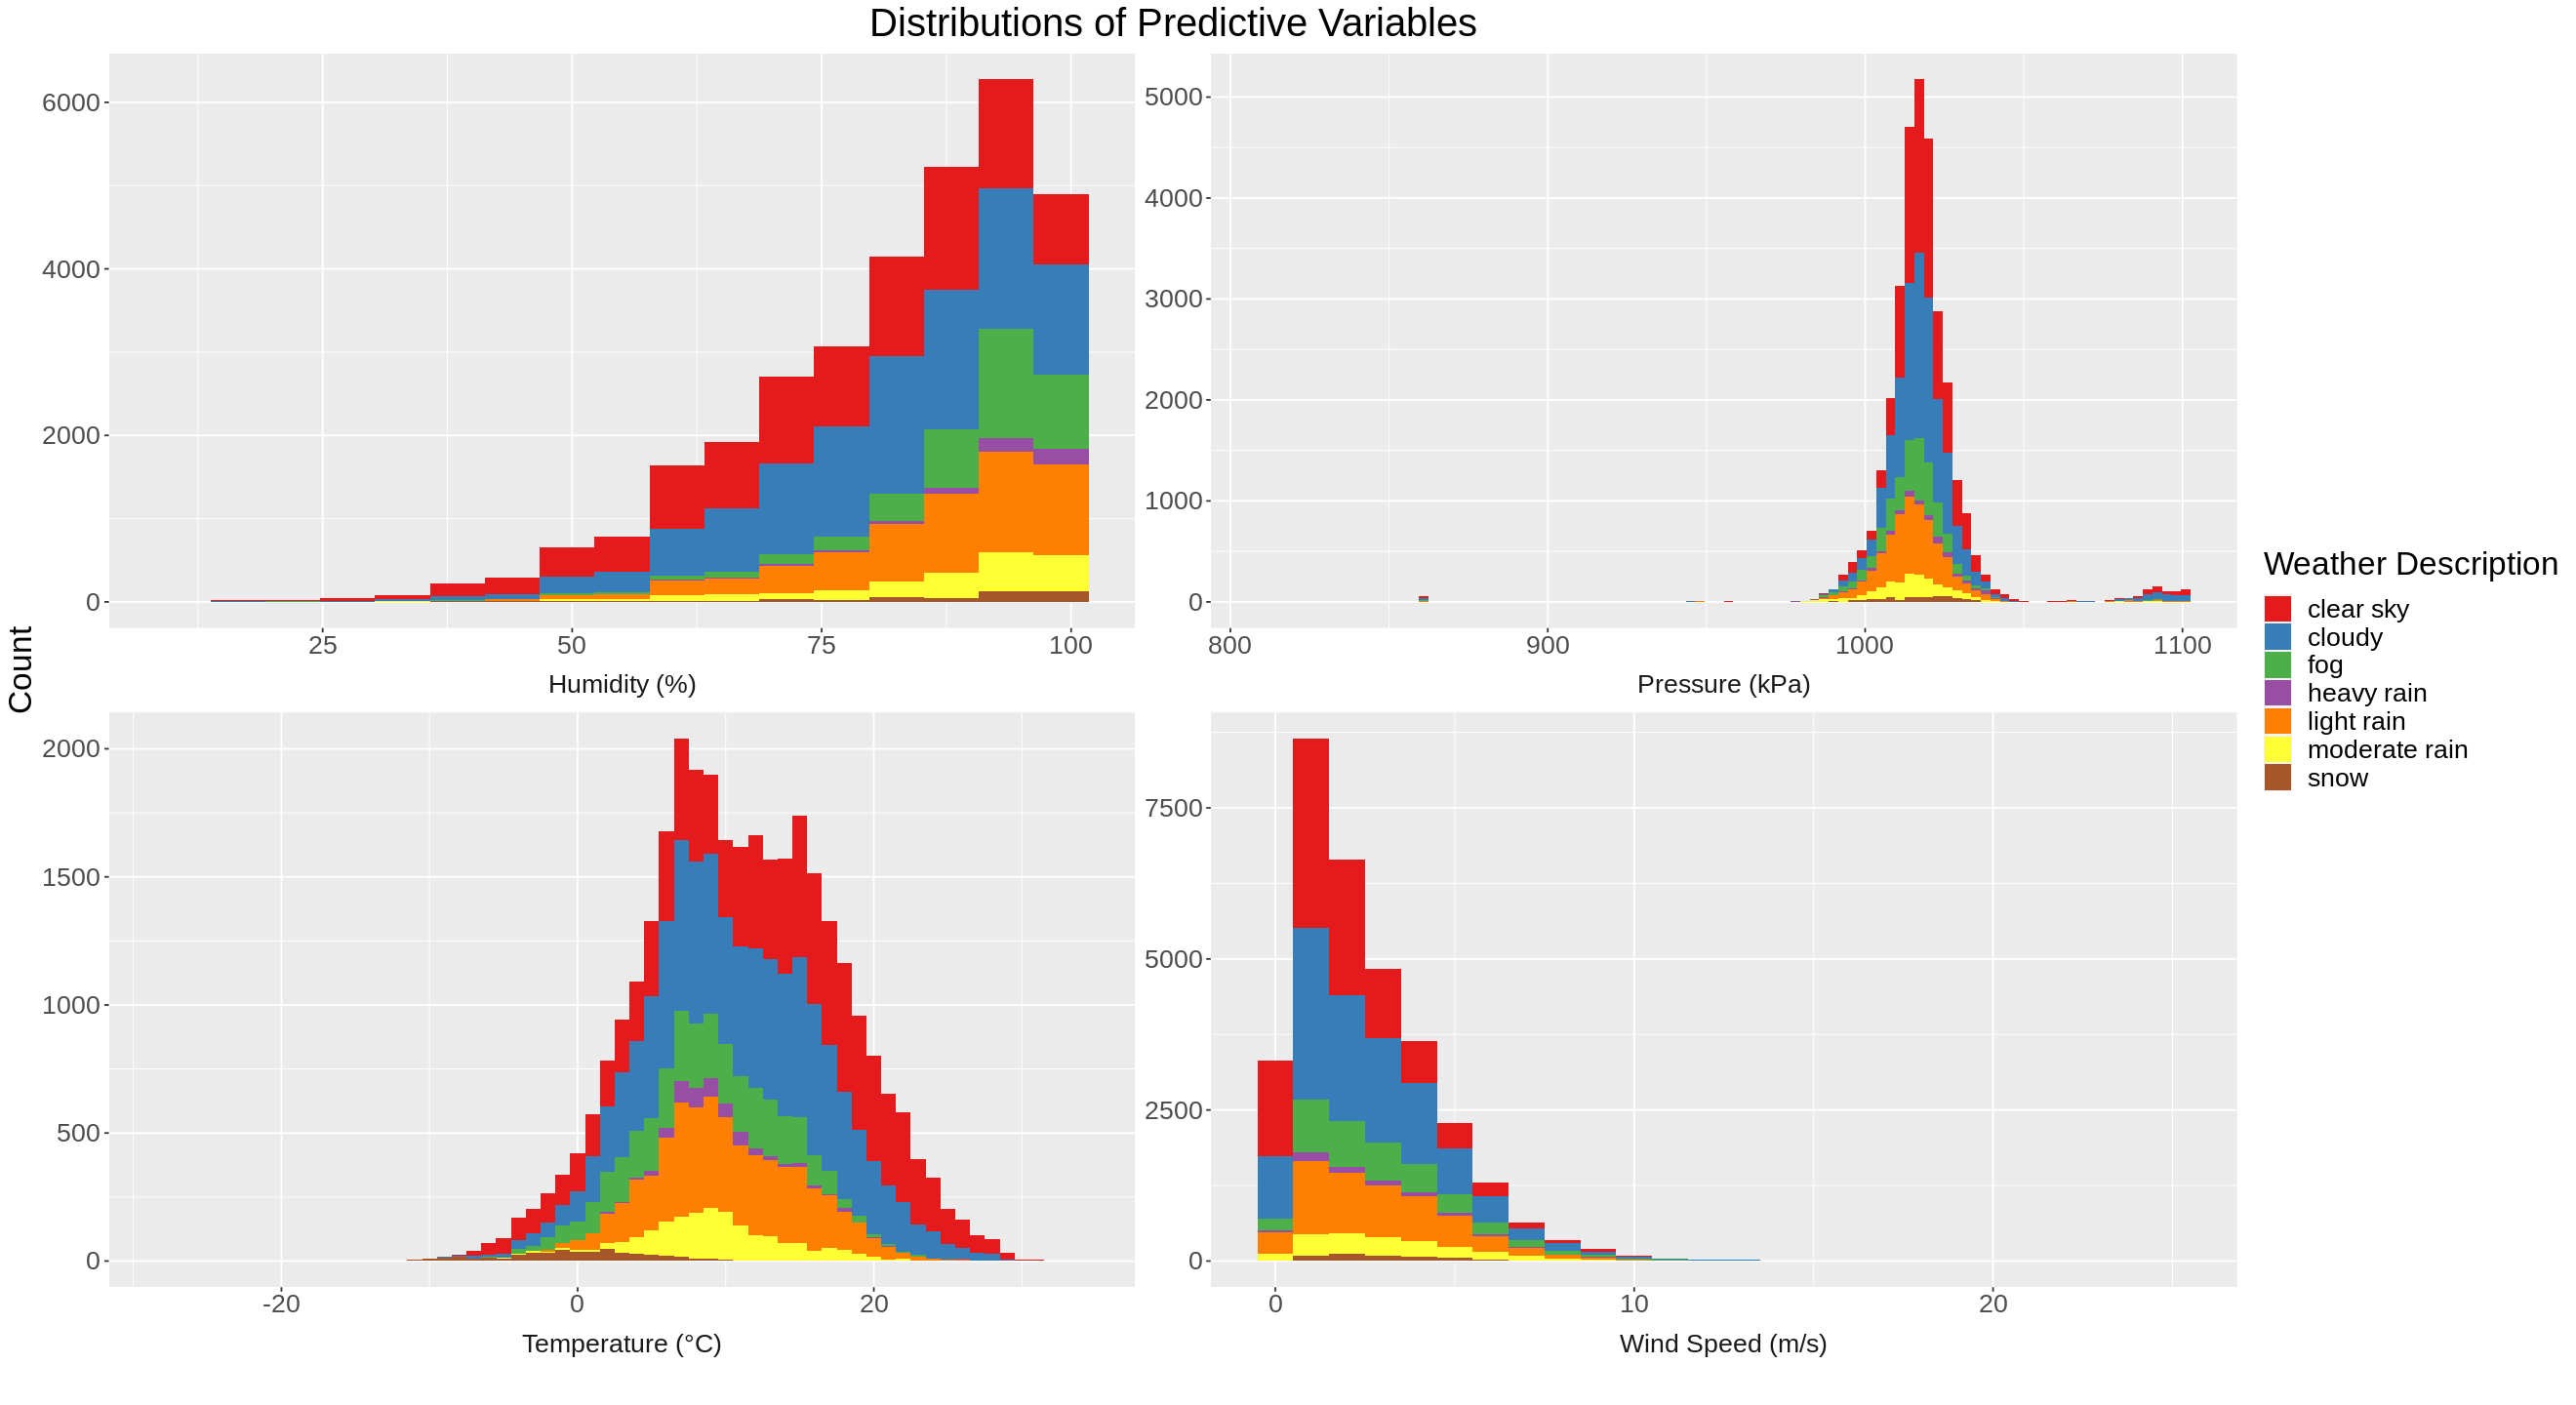

In [42]:
options(repr.plot.width = 22, repr.plot.height = 12) 

hist_data = pivot_longer(weather_train, c(temperature.c, pressure.kpa, humidity.pct, wind_speed.ms), 
            names_to = "measurement", values_to = "value")
hist_labels = as_labeller(c("humidity.pct" = "Humidity (%)", "pressure.kpa" = "Pressure (kPa)", "temperature.c" = "Temperature (°C)", "wind_speed.ms" = "Wind Speed (m/s)"))

hist_plot = ggplot(hist_data, aes(x = value, fill = description)) +
            ggtitle("Distributions of Predictive Variables") +
            geom_histogram(data = subset(hist_data, measurement == "humidity.pct"), binwidth = 5.5) + 
            geom_histogram(data = subset(hist_data, measurement == "pressure.kpa"), binwidth = 3) + 
            geom_histogram(data = subset(hist_data, measurement == "temperature.c"), binwidth = 1) + 
            geom_histogram(data = subset(hist_data, measurement == "wind_speed.ms"), binwidth = 1) + 
            facet_wrap(~measurement, scales = "free", strip.position = "bottom",  
                    labeller = hist_labels) +
            labs(x = "", y = "Count", fill = "Weather Description") + 
            scale_fill_brewer(palette = "Set1") +
            theme(strip.placement = "outside", strip.background = element_blank(), text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

hist_plot

*Figure 1.2*

Due to the large and chaotic nature of the dataset, we have chosen to use parallel histograms to visualize the dataset, rather than scatter plots. We make four histograms for each predictor and color according to the weather that makes up the observation. While these graphs show large clustering, the distributions do additionally show unique patterning for each weather, even though it is hard to percieve.

Due to the complex nature of weather, we have chose these predictive variable from meteorological evidence about weather patterns, since multivariate correlation is hard to visualize or intuitively see. As such, we have chosen to focus on the four fundemental meteoroligical predictors: temperature, wind speed, humitidy and pressure for our k-nearest neighbour classification model.  (citation to come)

#### Modeling:

We standardize and upsample the training data first, then setting model and recipe, using neighbors = tune() and all the predictors we outlined in our visualization, to find the best k and doing 5-fold cross-validation, then visualizing the results.

##### Model Declaration

In [17]:
set.seed(1234)

weather_recipe <- recipe(description ~ humidity.pct + pressure.kpa + temperature.c + wind_speed.ms, data = weather_train) %>% 
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    themis::step_upsample(description, over_ratio = 1)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine('kknn') %>% 
    set_mode('classification')

weather_vfold <- vfold_cv(weather_train, v=5, strata = description)

knn_workflow <- workflow() %>% 
    add_recipe(weather_recipe) %>% 
    add_model(knn_tune)

Note: The cross validation cells were run offline, due to being computationally expensivve, but the resultant graph is attatched, as if it were run within this notebook.

![](https://raw.githubusercontent.com/StuartLiv/DSCI100Group/Stuart/data/Rplot.png)

*Figure 2.0*

From Figure 2.0, we choose k=2 for the final model.

In [18]:
k<-2

knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = k) %>% 
    set_engine('kknn') %>% 
    set_mode('classification')

weather_fit = workflow() %>% 
    add_recipe(weather_recipe) %>% 
    add_model(knn_spec) %>% 
    fit(data = weather_train)

In [46]:
weather_predictions = predict(weather_fit, weather_test) %>% 
    bind_cols(weather_test)

weather_metrics = metrics(weather_predictions, 
                          truth = description, estimate = .pred_class)

weather_conf_mat = conf_mat(weather_predictions, 
                          truth = description, estimate = .pred_class)

weather_metrics
weather_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4383510
kap,multiclass,0.2559866


               Truth
Prediction      clear sky cloudy  fog heavy rain light rain moderate rain snow
  clear sky          1100    454  107         15        177            59   26
  cloudy              750   1457  288         45        356           120   34
  fog                 180    241  288          7        195            54   15
  heavy rain           13     24   11         35         17            14    1
  light rain          278    344  144         11        465            69   10
  moderate rain        65    134   62         14         66           131    2
  snow                 33     25   19          1         14             2   33

Our final tested accuracy is 43.8%, which is notably rather low. We have thus further performed some more visualization to percieve the accuracy per class.

##### Prediction Visualization

`summarise()` regrouping output by 'description' (override with `.groups` argument)



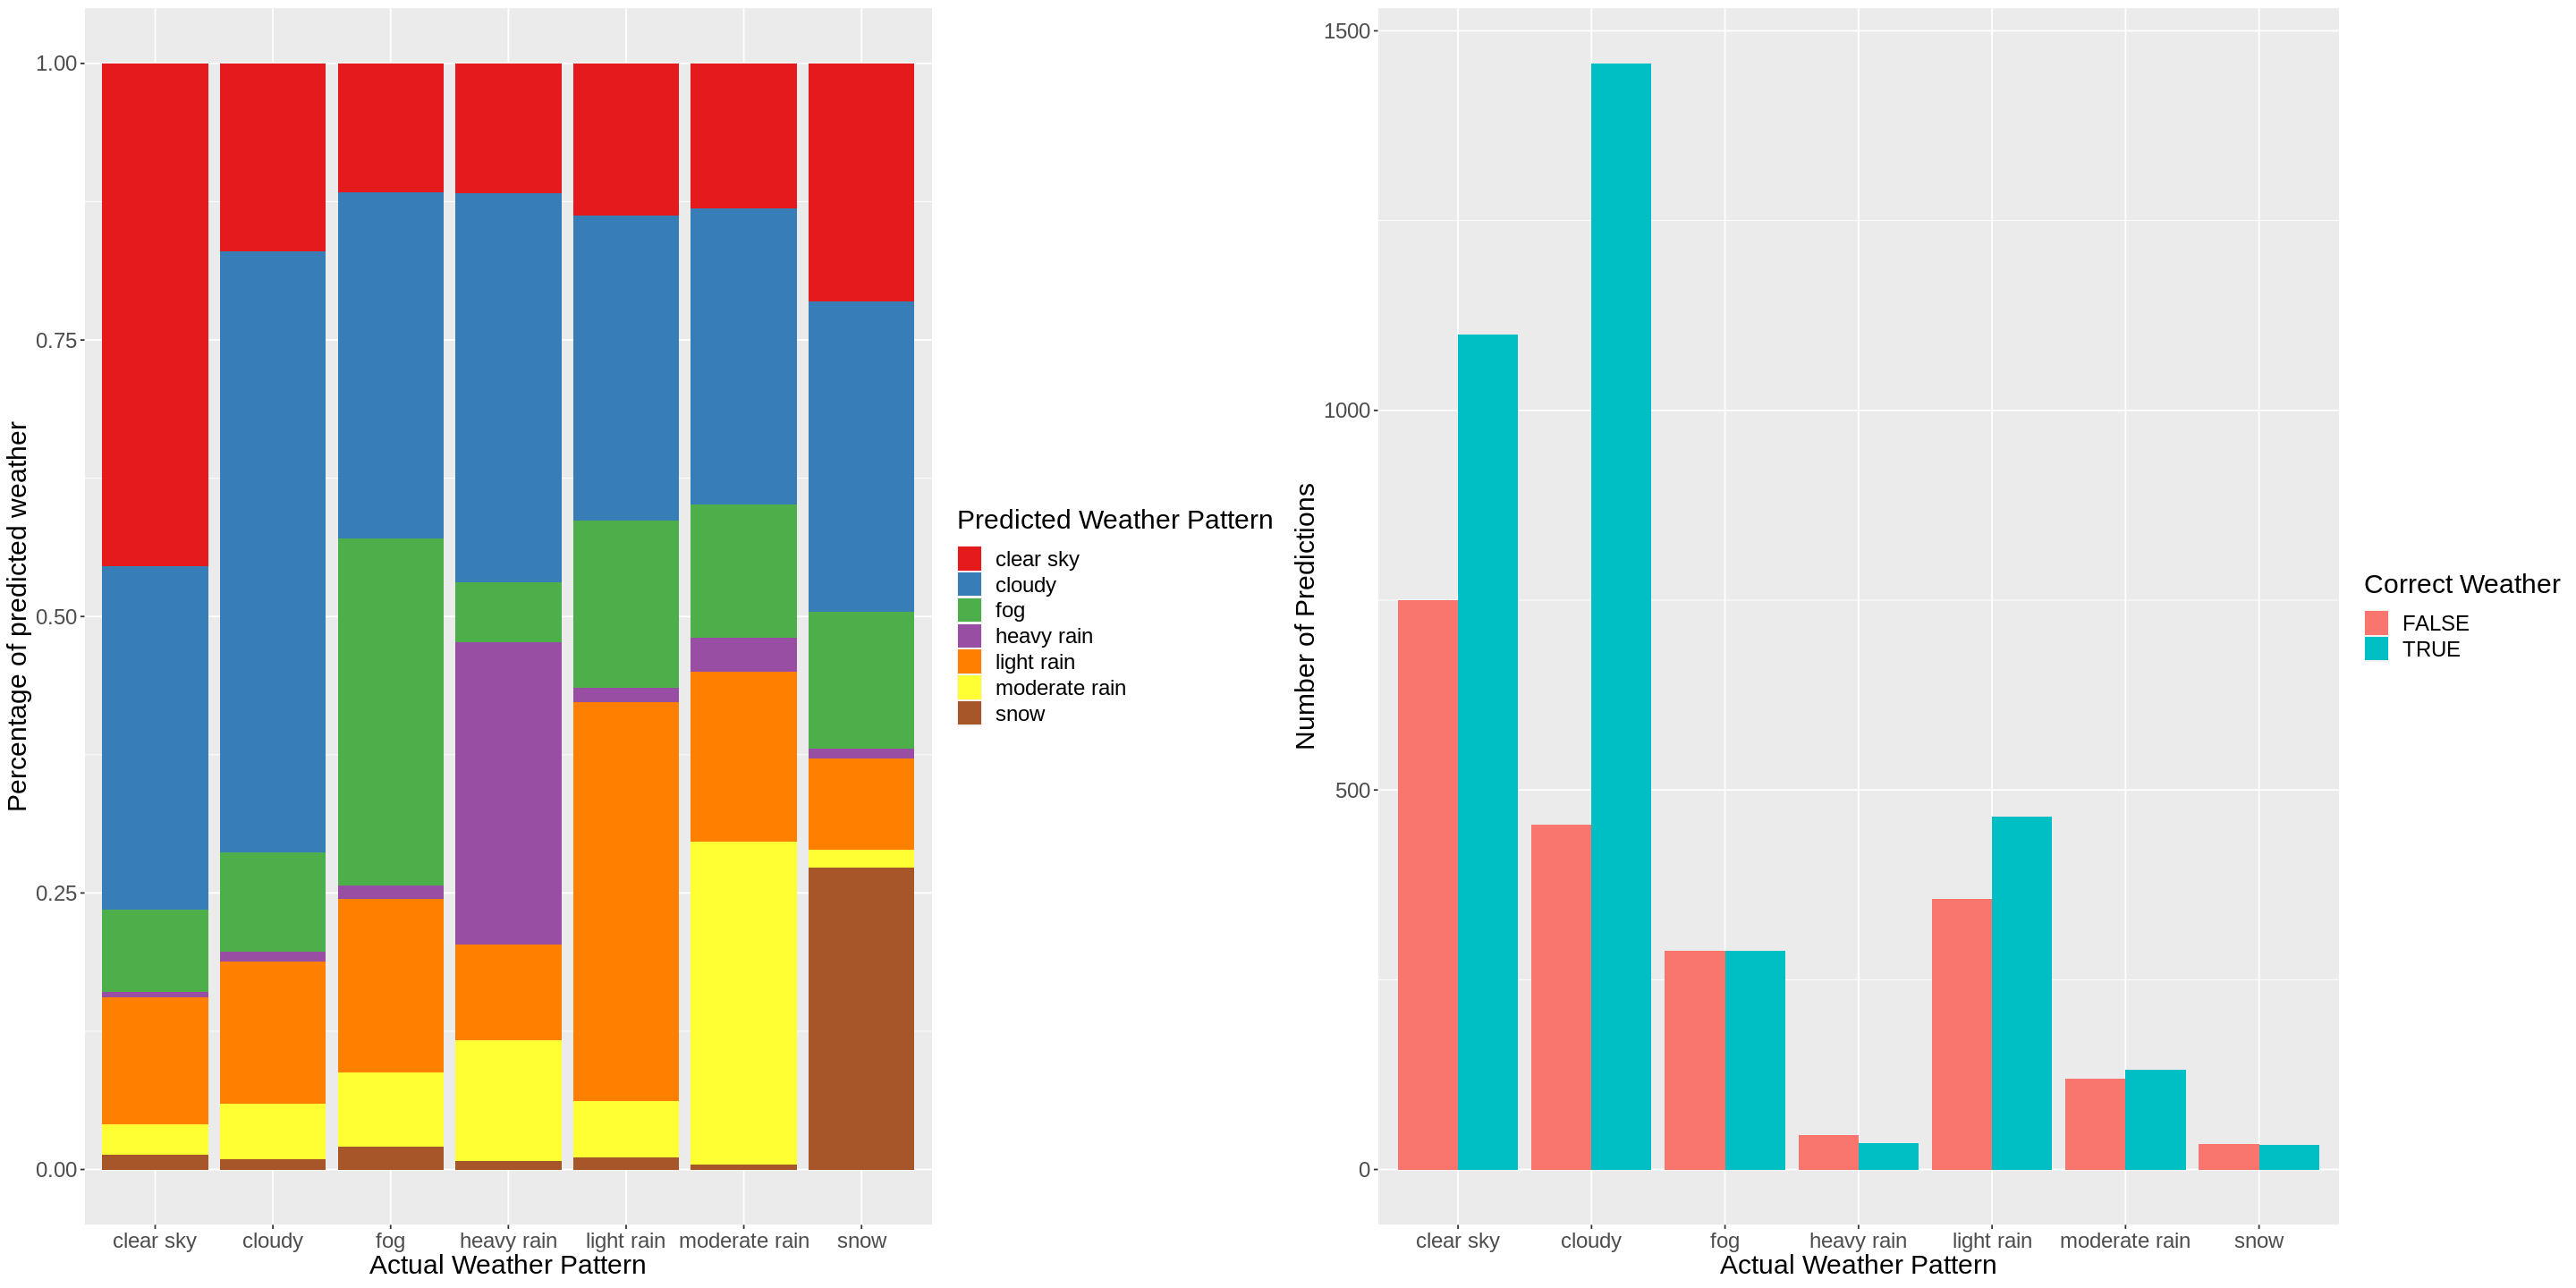

In [35]:
options(repr.plot.width = 24, repr.plot.height = 12) 

bar_data = select(weather_predictions, .pred_class, description) %>%
    group_by(description, .pred_class) %>%
    summarize(n=n())

bar_pred_plot = ggplot(bar_data, aes(x = description, y = n, fill = .pred_class)) + 
  geom_bar(stat = "identity", position = "fill") + 
  xlab("Actual Weather Pattern") +
  ylab("Percentage of predicted weather") +
  labs(fill = "Predicted Weather Pattern") +
  scale_fill_brewer(palette = "Set1") +
  theme(text = element_text(size = 18))

bar_data_binary = bar_data %>%
    mutate(.pred_class = (.pred_class == description))

bar_pred_bin = ggplot(bar_data_binary, aes(x = description, y = n, fill = .pred_class)) + 
  geom_bar(stat = "identity", position = "dodge") + 
  xlab("Actual Weather Pattern") +
  ylab("Number of Predictions") +
  labs(fill = "Correct Weather") +
  theme(text = element_text(size = 18))

plot_grid(bar_pred_plot, bar_pred_bin, ncol = 2)

*Figures 2.1 and 2.2*

### Discussion

We found that our model gives a false prediction most of the time. According to our results, the accuracy of our classification model in predicting the weather type based on quantitative predictors such as humidity, pressure, temperature, and wind speed is about 43.84%. The prediction results have a clear bias toward the cloudy pattern, as shown in Figure 2.1, result which fits our expectations since in the original dataset that we used to train the model, cloudy was one of the most common observations. However, the bias towards the clear sky is not as clear as cloudy. This is probably because the temperature and humidity statistics for clear sky and cloudy are very similar, but we have more cloudy data in our training set than for clear sky. While all the observations are dominated by these two patterns, it is noteworthy that the largest share of predicted weather for each pattern was always within the actual group, such as snow, or heavy rain, where the dominant majority of all observations predicted as that are in their own group.

Our results indicate that k-nearest neighbour classification is not a good choice for predicting a categorical variable from a chaotic system like weather using quantitative data, since this estimate accuracy is so low. Even in the most successful class, cloudy, the accuracy was only 52%, which is still very low. The impact of our findings is that we should look for other prediction methods for predicting a model as chaotic as weather, or perhaps a less noisy dataset with a more even distribution of weather data types when training our prediction models. Moreover, it seems that weather might be too complex of a system to be predicted using only four quantitative predictors – we might want to explore prediction methods using more quantitative predictors, such a geographic information, or more detailed precipitation data, and maybe even include some qualitative observations. Overall, this suggests a modeling method other than k-nearest neighbour. 

Further questions this analysis could lead to are: Are there any subsets of weather data able to be modeled by k-nearest neigbour classification considering the fact that chaotic systems have short-term patterns and repetition? Will KNN regression work better with a chaotic system like the weather? If so, will factors like global warming greatly affect the accuracy of those results long term? 


### References

Beniaguev, D. (2017, December 28). Historical hourly weather data 2012-2017. Kaggle. Retrieved February 27, 2022, from https://www.kaggle.com/selfishgene/historical-hourly-weather-data 

Lorenz, E. (1963). Deterministic Nonperiodic Flow. Journal of the Atmospheric Sciences,	20(2), 130-141. [https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2)

Weyn, Jonathan A., et al. (2019). Can Machines Learn to Predict Weather? Using DeepLearning to Predict Gridded 500‐hPa Geopotential Height From Historical Weather Data. Journal of Advances in Modeling Earth Systems, 11(8), 2680-2693.
https://doi.org/10.1029/2019MS001705

Total Words: 1000